In [1]:
import os
import glob
import random
import pandas as pd
import numpy as np
import openslide
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import json

In [3]:
def generate_tissueClsmask(wsi_path=None, anno_pt=None):
    slide=openslide.OpenSlide(wsi_path)
    with open(anno_pt, "r") as f:
        shapes = json.load(f)
    
    level = slide.level_count - 1
    scale_factor = 1/slide.level_downsamples[level]
    width, height = slide.level_dimensions[level]
    
    background = np.zeros((height, width, 3), np.uint8)
    mask = np.full((height, width, 3), background, dtype=np.uint8)
    
    for shape in shapes["features"]:
        points = shape["geometry"]["coordinates"][0]
        points = np.array([(p[0], p[1]) for p in points])
        points = points * scale_factor
        points = points.astype(int)
    
        cls = shape["properties"]["classification"]["name"]
        if cls == "epithelials":
          color = (255, 0, 0)
          mask = cv2.drawContours(mask, [points], -1, color=color, thickness=1)
          mask = cv2.fillPoly(mask, [points], color=color)
        elif cls == "stroma":
          color = (0, 255, 0)
          mask = cv2.drawContours(mask, [points], -1, color=color, thickness=1)
          mask = cv2.fillPoly(mask, [points], color=color)
        elif cls == "miscellaneous":
          color = (0, 0, 255)
          mask = cv2.drawContours(mask, [points], -1, color=color, thickness=1)
          mask = cv2.fillPoly(mask, [points], color=color)
        
    return mask
     
    

def plot_multiple(img_list, caption_list, grid_x, grid_y, figure_size, cmap, save_pt=None):
    fig, axes = plt.subplots(grid_x, grid_y, figsize=figure_size)
    counter = 0
    for x in range(0, grid_x):
        for y in range(0, grid_y):
            axes[x][y].imshow(img_list[counter],cmap=cmap)
            axes[x][y].axis("off")
            axes[x][y].set_title(f"{caption_list[counter]}")
            counter += 1
    if save_pt is not None:
        plt.title(os.path.basename(save_pt).split(".png")[0])
        plt.savefig(save_pt, pad_inches=0, bbox_inches="tight")


(-0.5, 286.5, 209.5, -0.5)

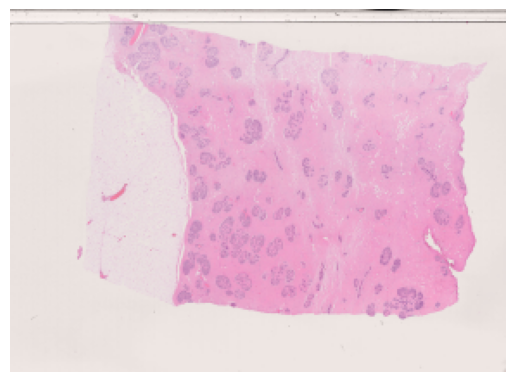

In [11]:
wsi_folder = '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/WSIs/KHP_RM/'
anno_file = '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/Manual_anno/KHP/19001626-IncN FPE-3-FPESec-1 - 2022-02-22 18.32.geojson'
wsiname = '19001626_FPE_3'
wsi_file = os.path.join(wsi_folder, wsiname+'.ndpi')


wsi=openslide.OpenSlide(wsi_file)
img = wsi.read_region((0,0), wsi.level_count-1, wsi.level_dimensions[wsi.level_count-1]).convert('RGB')
plt.imshow(img)
plt.axis('off')

(-0.5, 286.5, 209.5, -0.5)

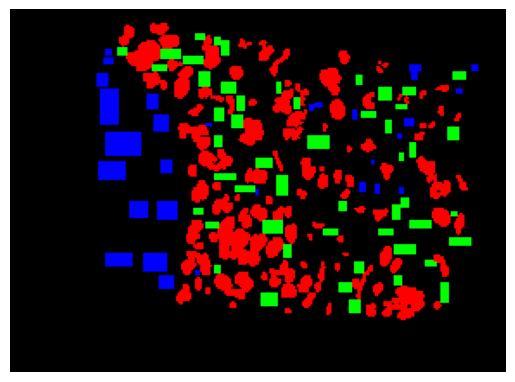

In [12]:
mask = generate_tissueClsmask(wsi_file, anno_file)
plt.imshow(mask)
plt.axis('off')